<a href="https://colab.research.google.com/github/tozanni/Data_Science_Notebooks/blob/main/ch2_vae_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejercicio capítulo 2 del libro "Hands-On Image Generation with Tensorflow" de Soon Yau Cheong.

https://subscription.packtpub.com/book/data/9781838826789/2

Adaptaciones menores al notebook y comentarios en español (EHR).

Este notebook fue probado en Google Colab con Python 3.8 y Tensorflow 2.8.2

In [1]:
# Esto no se requiere
# !pip3 uninstall tensorflow
# !pip3 install tensorflow_gpu==2.3.1

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Reshape, Lambda, Dropout
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datetime, os
import warnings
warnings.filterwarnings('ignore')

# from packaging.version import parse as parse_version
#assert parse_version(tf.__version__) < parse_version("2.4.0"), \
#    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

In [2]:
tf.__version__

'2.8.2'

# Multi-GPUs
This notebook will use multiple GPUs to speed up training if they are available. Otherwise, a single GPU will be used.

In [3]:
strategy = tf.distribute.MirroredStrategy()
num_devices = strategy.num_replicas_in_sync
print('Number of devices: {}'.format(num_devices))

Number of devices: 1


## Load Image dataset
Sometimes the download of celeb_a can fail due to Google's server limiting number of download. If fails, then proceed to the next cell to download the dataset manually.

In [4]:
(ds_train, ds_test_), ds_info = tfds.load('celeb_a', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/162770 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/celeb_a/2.0.1.incomplete1WG6O6/celeb_a-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/19867 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/celeb_a/2.0.1.incomplete1WG6O6/celeb_a-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/celeb_a/2.0.1.incomplete1WG6O6/celeb_a-test.tfrecord*...:   0%|          | 0/1…

Dataset celeb_a downloaded and prepared to ~/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


## Manual download of dataset
Uncomment the cell to download dataset manually.

In [5]:
'''
import gdown
url = 'https://drive.google.com/uc?id=1tCj_CKUgjtThk1fiL0wP0WiuYxk4dvjT'
tfds_rootdir = '/root/' # for Google Colab
#tfds_rootdir = '~/' # for Linux

file_path = os.path.join(tfds_rootdir, 'tensorflow_datasets/celeb_a.zip')
file_dir = file_path.replace('.zip','')
gdown.download(url, file_path, quiet=False)

!unzip $file_path -d $file_dir

(ds_train, ds_test_), ds_info = tfds.load('celeb_a', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              with_info=True)
'''

"\nimport gdown\nurl = 'https://drive.google.com/uc?id=1tCj_CKUgjtThk1fiL0wP0WiuYxk4dvjT'\ntfds_rootdir = '/root/' # for Google Colab\n#tfds_rootdir = '~/' # for Linux\n\nfile_path = os.path.join(tfds_rootdir, 'tensorflow_datasets/celeb_a.zip')\nfile_dir = file_path.replace('.zip','')\ngdown.download(url, file_path, quiet=False)\n\n!unzip $file_path -d $file_dir\n\n(ds_train, ds_test_), ds_info = tfds.load('celeb_a', \n                              split=['train', 'test'], \n                              shuffle_files=True,\n                              with_info=True)\n"

In [6]:
batch_size = 128*num_devices

def preprocess(sample):
    image = sample['image']
    image = tf.image.resize(image, [112,112])
    image = tf.cast(image, tf.float32)/255.
    return image, image

ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(batch_size*4)
ds_train = ds_train.batch(batch_size).prefetch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).prefetch(batch_size)

train_num = ds_info.splits['train'].num_examples
test_num = ds_info.splits['test'].num_examples

# Building VAE

In [7]:
class GaussianSampling(Layer):        
    def call(self, inputs):
        means, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(means), mean=0., stddev=1.)
        samples = means + tf.exp(0.5*logvar)*epsilon

        return samples
    
class DownConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), strides=1, padding='same'):
        super(DownConvBlock, self).__init__(name=f"DownConvBlock_{DownConvBlock.count}")
        DownConvBlock.count+=1
        self.forward = Sequential([Conv2D(filters, kernel_size, strides, padding)])
        self.forward.add(BatchNormalization())
        self.forward.add(layers.LeakyReLU(0.2))
        
    def call(self, inputs):
        return self.forward(inputs)

class UpConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), padding='same'):
        super(UpConvBlock, self).__init__(name=f"UpConvBlock_{UpConvBlock.count}")
        UpConvBlock.count += 1
        self.forward = Sequential([Conv2D(filters, kernel_size, 1, padding),])
        self.forward.add(layers.LeakyReLU(0.2))
        self.forward.add(UpSampling2D((2,2)))
        
    def call(self, inputs):
        return self.forward(inputs)
    
class Encoder(Layer):
    def __init__(self, z_dim, name='encoder'):
        super(Encoder, self).__init__(name=name)
        
        self.features_extract = Sequential([
            DownConvBlock(filters = 32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters = 32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters = 64, kernel_size=(3,3), strides=2),
            DownConvBlock(filters = 64, kernel_size=(3,3), strides=2),
            Flatten()])
        
        self.dense_mean = Dense(z_dim, name='mean')
        self.dense_logvar = Dense(z_dim, name='logvar')
        self.sampler = GaussianSampling()
        
    def call(self, inputs):
        x = self.features_extract(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        z = self.sampler([mean, logvar])
        return z, mean, logvar

class Decoder(Layer):
    def __init__(self, z_dim, name='decoder'):
        super(Decoder, self).__init__(name=name)
            
        self.forward = Sequential([
                        Dense(7*7*64, activation='relu'),
                        Reshape((7,7,64)),
                        UpConvBlock(filters=64, kernel_size=(3,3)),
                        UpConvBlock(filters=64, kernel_size=(3,3)),
                        UpConvBlock(filters=32, kernel_size=(3,3)),
                        UpConvBlock(filters=32, kernel_size=(3,3)),
                        Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid'),
                
        ])

    def call(self, inputs):
        return self.forward(inputs)

    
class VAE(Model):
    def __init__(self, z_dim, name='VAE'):
        super(VAE, self).__init__(name=name)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.mean = None
        self.logvar = None
        
    def call(self, inputs):
        z, self.mean, self.logvar = self.encoder(inputs)
        out = self.decoder(z)           
        return out
    

# Fit and Train

In [8]:
if num_devices>1:
    with strategy.scope():
        vae = VAE(z_dim=200)
else:
    vae = VAE(z_dim=200)

In [9]:
def vae_kl_loss(y_true, y_pred):
    kl_loss =  - 0.5 * tf.reduce_mean(1 + vae.logvar - tf.square(vae.mean) - tf.exp(vae.logvar))
    return kl_loss    

def vae_rc_loss(y_true, y_pred):
    #rc_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    rc_loss = tf.keras.losses.MSE(y_true, y_pred)
    return rc_loss

def vae_loss(y_true, y_pred):
    kl_loss = vae_kl_loss(y_true, y_pred)
    rc_loss = vae_rc_loss(y_true, y_pred)
    kl_weight_const = 0.01
    return kl_weight_const*kl_loss + rc_loss

In [10]:
model_path = "./models/my_vae_celeb_a.h5"
os.makedirs("./models", exist_ok=True)
EPOCHS = 5

checkpoint = ModelCheckpoint(model_path, 
                             monitor= "vae_rc_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "vae_rc_loss", 
                      mode= "auto", 
                      patience = 3)

callbacks_list = [checkpoint, early]

initial_learning_rate = 1e-3
steps_per_epoch = int(np.round(train_num/batch_size))
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=0.96,
    staircase=True)

vae.compile(
    loss = [vae_loss],
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-3),
    metrics=[vae_kl_loss,vae_rc_loss])


history = vae.fit(ds_train, validation_data=ds_test,
                epochs = EPOCHS, callbacks = callbacks_list)

Epoch 1/5
1272/1272 [==============================] - ETA: 0s - loss: 4.8296 - vae_kl_loss: 478.9551 - vae_rc_loss: 0.0387
Epoch 1: vae_rc_loss improved from inf to 0.03874, saving model to ./models/my_vae_celeb_a.h5
1272/1272 [==============================] - 144s 99ms/step - loss: 4.8296 - vae_kl_loss: 478.9551 - vae_rc_loss: 0.0387 - val_loss: 0.0224 - val_vae_kl_loss: 0.5205 - val_vae_rc_loss: 0.0172
Epoch 2/5
1272/1272 [==============================] - ETA: 0s - loss: 0.0214 - vae_kl_loss: 0.4337 - vae_rc_loss: 0.0171
Epoch 2: vae_rc_loss improved from 0.03874 to 0.01705, saving model to ./models/my_vae_celeb_a.h5
1272/1272 [==============================] - 131s 103ms/step - loss: 0.0214 - vae_kl_loss: 0.4337 - vae_rc_loss: 0.0171 - val_loss: 0.0188 - val_vae_kl_loss: 0.4736 - val_vae_rc_loss: 0.0141
Epoch 3/5
1272/1272 [==============================] - ETA: 0s - loss: 0.0194 - vae_kl_loss: 0.4379 - vae_rc_loss: 0.0150
Epoch 3: vae_rc_loss improved from 0.01705 to 0.01498, sa

# Uncomment the following cell to load pretrained model

In [11]:
'''
model_path = "./models/vae_celeb_a.h5"
vae.load_weights(model_path)
'''

'\nmodel_path = "./models/vae_celeb_a.h5"\nvae.load_weights(model_path)\n'

# Reconstruct Images

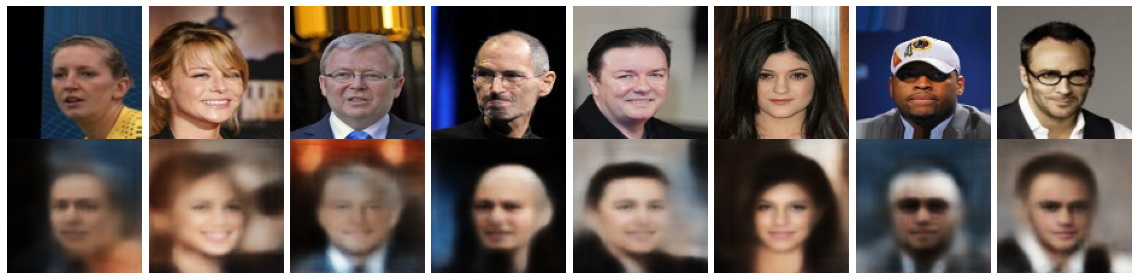

In [12]:
images, labels = next(iter(ds_train))
vae.load_weights(model_path)
outputs = vae.predict(images)

# Display
grid_col = 8
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2, grid_row*2))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i])
        axarr[row+1,col].axis('off')        
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()

# Look at the Z distributions

In [13]:
#EHR: Usar False, opcion True aun no soportada
# Set to False to calculate the statistic but it can be slow
load_from_file = False 

if load_from_file:
    stats = pickle.load(open('stats.p','wb'))
    avg_z_mean = stats['avg_z_mean']
    avg_z_std = stats['avg_z_std']
else:    
    avg_z_mean = []
    avg_z_std = []
    for i in range(steps_per_epoch):
        images, labels = next(iter(ds_train))    
        z, z_mean, z_logvar = vae.encoder(images)
        avg_z_mean.append(np.mean(z_mean, axis=0))
        avg_z_std.append(np.mean(np.exp(0.5*z_logvar),axis=0))

    avg_z_mean = np.mean(avg_z_mean, axis=0)
    avg_z_std = np.mean(avg_z_std, axis=0)


Text(0.5, 0, 'z dimension')

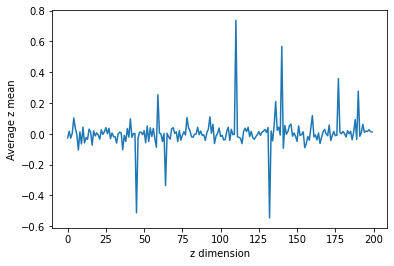

In [14]:
plt.plot(avg_z_mean)
plt.ylabel("Average z mean")
plt.xlabel("z dimension")

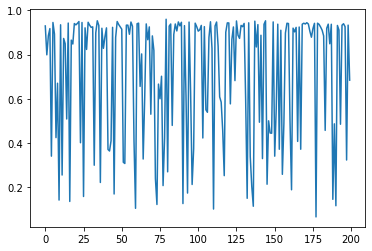

In [15]:
plt.plot(avg_z_std)

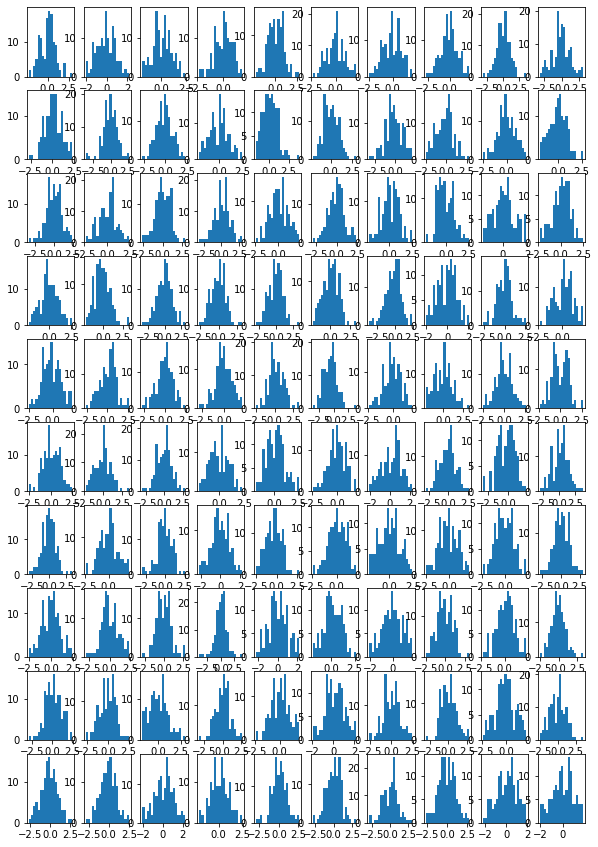

In [16]:
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, 1.5*grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].hist(z[:,i], bins=20)
        #axarr[row,col].axis('off')   
        i += 1

#f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show() 



# Generate Samples

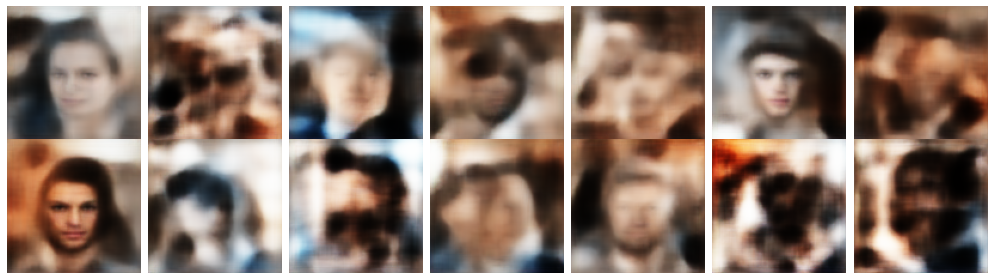

In [17]:
z_dim = 200
z_samples = np.random.normal(loc=0, scale=1, size=(25, z_dim))
images = vae.decoder(z_samples.astype(np.float32))
grid_col = 7
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')   
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show() 

# Sampling Trick

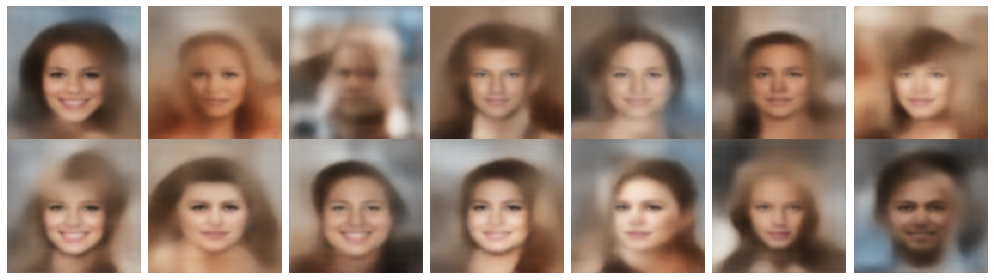

In [18]:
z_samples = np.random.normal(loc=0, scale=np.mean(avg_z_std), size=(25, z_dim))
z_samples += avg_z_mean

images = vae.decoder(z_samples.astype(np.float32))
grid_col = 7
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')   
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show() 

# Latent variables exploration

In [19]:
(ds_train, ds_test), ds_info = tfds.load('celeb_a', 
                              split=['train','test'], 
                              shuffle_files=True,
                              with_info=True)

test_num = ds_info.splits['test'].num_examples

In [20]:
def preprocess_attrib(sample, attribute):
    image = sample['image']
    image = tf.image.resize(image, [112,112])
    image = tf.cast(image, tf.float32)/255.
    return image, sample['attributes'][attribute]

attribute = 'Smiling'

In [21]:
def extract_attrib_vector(attribute, ds):
    batch_size = 128*num_devices
    ds = ds.map(lambda x: preprocess_attrib(x, attribute))
    ds = ds.batch(batch_size)

    steps_per_epoch = int(np.round(test_num/batch_size))

    pos_z = []
    pos_z_num = []
    neg_z = []
    neg_z_num = []

    for i in range(steps_per_epoch):
        images, labels = next(iter(ds))
        z, z_mean, z_logvar = vae.encoder(images)
        z = z.numpy()
        step_pos_z = z[labels==True]
        pos_z.append(np.mean(step_pos_z, axis=0))
        pos_z_num.append(step_pos_z.shape[0])

        step_neg_z = z[labels==False]
        neg_z.append(np.mean(step_neg_z, axis=0))
        neg_z_num.append(step_neg_z.shape[0])

    avg_pos_z = np.average(pos_z, axis=(0), weights=pos_z_num)
    avg_neg_z = np.average(neg_z, axis=(0), weights=neg_z_num)
    attrib_vector = avg_pos_z - avg_neg_z
    return attrib_vector

In [22]:
if load_from_file:
    attribs_vectors = pickle.load(open('attribs_vectors.p','wb'))
else:    
    attributes = list(ds_info.features['attributes'].keys())
    attribs_vectors = {}
    for attrib in attributes:
        print(attrib)
        attribs_vectors[attrib] = extract_attrib_vector(attrib, ds_test)

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [23]:
pickle.dump(attribs_vectors, open('attribs_vectors.p','wb'))
pickle.dump({'mean':avg_z_mean, 'std':avg_z_std}, open('stats.p','wb'))

In [24]:
def explore_latent_variable(image, attrib):
    grid_col = 8
    grid_row = 1
    
    z_samples, _, _ = vae.encoder(tf.expand_dims(image, 0))
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))

    i = 0
    row = 0
    step = -3

    axarr[0].imshow(image)
    axarr[0].axis('off')
    for col in range(1, grid_col):
        new_z_samples = z_samples + step*attribs_vectors[attrib]
        reconstructed_image = vae.decoder(new_z_samples)

        step +=1
        axarr[col].imshow(reconstructed_image[0])
        axarr[col].axis('off')   
        i += 1
    f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)         
    plt.show()

In [25]:
ds_test1 = ds_test.map(preprocess).batch(100)

In [26]:
images, labels = next(iter(ds_test1))

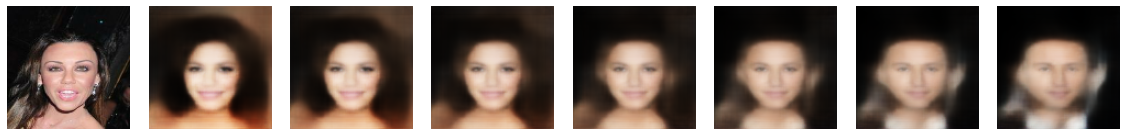

In [27]:
explore_latent_variable(images[31], "Male")

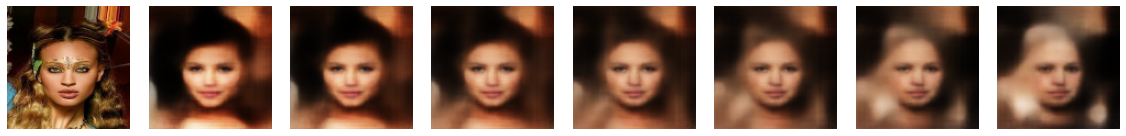

In [28]:
explore_latent_variable(images[29], "Eyeglasses")

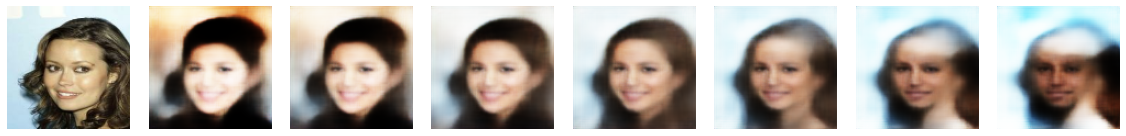

In [29]:
explore_latent_variable(images[10], "Chubby")

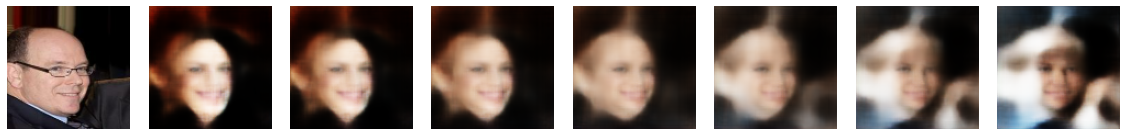

In [30]:
explore_latent_variable(images[7], "Mustache")

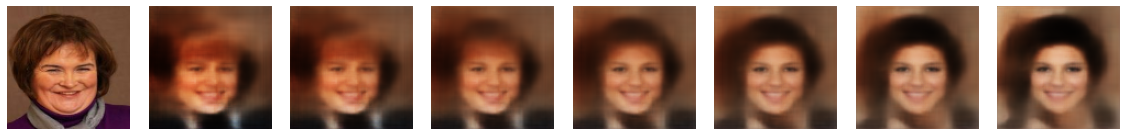

In [31]:
explore_latent_variable(images[6], "Young")

# Face editing via latent space exploration

In [32]:
# set file name to use own image, otherwise use random face
fname = "" 
if fname:
    # use existing image from file    
    image = cv2.imread(fname)
    image = image[:,:,::-1]

    # crop
    min_dim = min(h, w)
    h_gap = (h-min_dim)//2
    w_gap = (w-min_dim)//2
    image = image[h_gap:h-h_gap, w_gap:w-w_gap,:]

    image = cv2.resize(image, (112, 112))
    plt.imshow(image)

    # encode
    input_tensor = np.expand_dims(image, 0)
    input_tensor = input_tensor.astype(np.float32)/255.
    z_samples = vae.encoder(input_tensor)
else:
    # start with random image
    z_samples = np.random.normal(loc=0, scale=np.mean(avg_z_std), size=(1, 200))
    z_samples += avg_z_mean

In [34]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def explore_latent_variable(Male = (-5,5,0.1),
                            Eyeglasses = (-5,5,0.1),
                            Young = (-5,5,0.1),
                            Smiling = (-5,5,0.1),
                            Blond_Hair = (-5,5,0.1),
                            Pale_Skin = (-5,5,0.1),
                            Mustache = (-5,5,0.1)):
    new_z_samples = z_samples + \
                    Male*attribs_vectors['Male'] + \
                    Eyeglasses*attribs_vectors['Eyeglasses'] +\
                    Young*attribs_vectors['Young'] +\
                    Smiling*attribs_vectors['Smiling']+\
                    Blond_Hair*attribs_vectors['Blond_Hair'] +\
                    Pale_Skin*attribs_vectors['Pale_Skin'] +\
                    Mustache*attribs_vectors['Mustache']
    images = vae.decoder(new_z_samples.astype(np.float32))
    plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.imshow(images[0])

interactive(children=(FloatSlider(value=0.0, description='Male', max=5.0, min=-5.0), FloatSlider(value=0.0, de…